In [1]:
import pandas as pd
import numpy as np
import scipy.integrate as intgr
import scipy.stats as sts
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy.linalg as lin

In [2]:
#Q1a

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


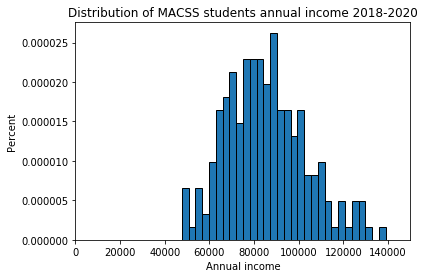

In [3]:
income = np.loadtxt('/Users/liujingyang/Desktop/incomes.txt')

count, bins, ignored = plt.hist(income, 30, edgecolor='k', normed=True)
plt.title('Distribution of MACSS students annual income 2018-2020')
plt.xlabel('Annual income')
plt.ylabel('Percent')
plt.xlim([0, 150000])
plt.show()

In [4]:
#Q1b

In [5]:
## Define the log-normal pdf function
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [6]:
## Define two data moments for GMM (mean(data),standard deviation(data)).

def data_moments(xvals):

    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [7]:
## Define two model moments for GMM (mean(model data),standard deviation(model data)).

def model_moments(mu, sigma, cut_lb, cut_ub):  
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)    
    std_model = np.sqrt(var_model)
    return mean_model, std_model

In [8]:
## Define vector of moment errors for GMM.

def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [9]:
def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [10]:
## Using Identity matrix

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) 
gmm_args = (income, 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)



mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(income, mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation =', std_model)
print('Error vector=', err1)
print('GMM criterion function:',results.fun)

mu_GMM1= 11.333599613401052  sig_GMM1= 0.2132552950928067
Mean of points = 85276.82360625811 , Standard Deviation of points = 17992.542128046523
Mean of model = 85276.82405854747 , Standard Deviation = 17992.541683009
Error vector= [ 5.3037782e-09 -2.4734555e-08]
GMM criterion function: [[6.39928276e-16]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


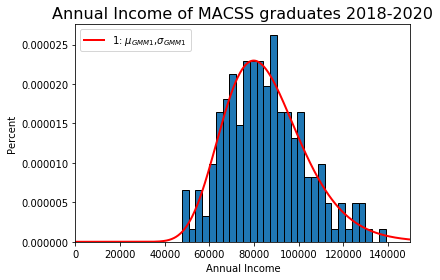

In [11]:
# Plot the histogram of data

count, bins, ignored = plt.hist(income, 30, density=True,
                                edgecolor='k')
plt.title('Annual Income of MACSS graduates 2018-2020', fontsize=16)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent')
plt.xlim([1, 150000])  

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

In [12]:
#Q1c

In [13]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [14]:
Err_mat = get_Err_mat2(income, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / income.shape[0]) * (Err_mat @ Err_mat.T)
print('VCV2:\n', VCV2)
W_hat2 = lin.inv(VCV2)
print('W_hat2:\n', W_hat2)

VCV2:
 [[4.45167060e-02 1.68385288e+03]
 [1.68385288e+03 9.54184437e+08]]
W_hat2:
 [[ 2.40701668e+01 -4.24767141e-05]
 [-4.24767141e-05  1.12297423e-09]]


In [15]:
## Using two moments, two steps optimal weighting matrix
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (income, 0.0, 150000.0, W_hat2)
results_2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mean_model_2, std_model_2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(income, mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard deviation of points =', std_data)
print('Mean of model =', mean_model_2, ', Standard deviation of model =', std_model_2)
print('Error vector =', err2)
print('GMM criterion function Value=', results_2.fun[0, 0])

mu_GMM2= 11.333599603618694  sig_GMM2= 0.21325529447620906
Mean of points = 85276.82360625811 , Standard deviation of points = 17992.542128046523
Mean of model = 85276.8232464362 , Standard deviation of model = 17992.541506074136
Error vector = [-4.21945734e-09 -3.45683441e-08]
GMM criterion function Value= 4.285285321889139e-16


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


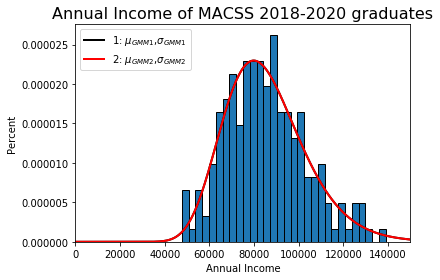

In [16]:
## Plot the histogram of data.


count, bins, ignored = plt.hist(income, 30, density=True,
                                edgecolor='k')
plt.title('Annual Income of MACSS 2018-2020 graduates', fontsize=16)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent')
plt.xlim([0, 150000])  

# Plot the estimated GMM PDF with I.
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='r', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')
plt.show()

In [17]:
#Q1d

In [18]:
## Define new data moments for GMM.

def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [19]:
## Define new model moments for GMM.

def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [20]:
## Define new vector of moment errors for GMM.

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [21]:
## Define new GMM weighted sum of squared moment errors criterion function value.

def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    return crit_val

In [22]:
W_hat_3 = np.eye(3)
gmm_args = (income, 0.0, 150000, W_hat_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM_3, sig_GMM_3 = results_3.x
print('mu_GMM_3 =', mu_GMM_3, ' sig_GMM_3 =', sig_GMM_3)
err3 = err_vec3(income, mu_GMM_3, sig_GMM_3, 0.0, 150000.0, False).reshape(3,)
print('Error vector:', err3)
print('GMM criterion function Value:',results_3.fun[0,0])

mu_GMM_3 = 11.336705179923449  sig_GMM_3 = 0.21151351610769975
Error vector: [ 1.13768317e-08  1.18261299e-08 -4.66305708e-08]
GMM criterion function Value: 2.4436997793444182e-15


In [23]:
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(income)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM_3, sig_GMM_3, 0.0, 150000.0)
data_mm = [bpct_1_dat, bpct_2_dat, bpct_3_dat]
model_mm = [bpct_1_mod, bpct_2_mod, bpct_3_mod]
ind = ['Percent < $75K','Percent \$75K - \$100K','Percent >= $100K']
data = {'Data Moments':data_mm, 'Model Moments': model_mm}
pd.DataFrame(data, index = ind)

,Data Moments,Model Moments
Percent < $75K,0.3,0.3
Percent \$75K - \$100K,0.5,0.5
Percent >= $100K,0.2,0.2


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


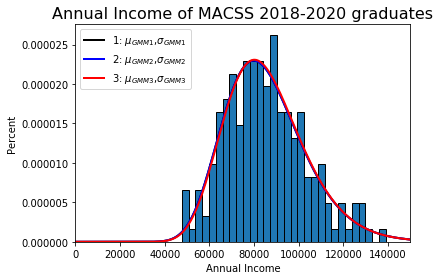

We find that there are almost no differences among these three estimates.


In [24]:
## Plot the histogram of data

count, bins, ignored = plt.hist(income, 30, density=True,
                                edgecolor='k')
plt.title('Annual Income of MACSS 2018-2020 graduates', fontsize=16)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent')
plt.xlim([0, 150000])  

# Plot the estimated GMM PDF
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='b', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM_3, sig_GMM_3, 0.0, 150000),
         linewidth=2, color='r', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')

plt.legend(loc='upper left')

plt.show()

print('We find that there are almost no differences among these three estimates.')


In [25]:
#Q1e

In [26]:
## Define R by N matrix of errors

def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [27]:
Err_mat3 = get_Err_mat3(income, mu_GMM_3, sig_GMM_3, 0.0, 150000.0, False)
VCV2_3 = (1 / income.shape[0]) * (Err_mat3 @ Err_mat3.T)
print('VCV2_3:\n', VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)
print('W_hat2_3:\n', W_hat2_3)

VCV2_3:
 [[ 2.33333328 -0.99999998 -1.00000004]
 [-0.99999998  0.99999998 -1.00000003]
 [-1.00000004 -1.00000003  4.00000037]]
W_hat2_3:
 [[ 0.25761773 -0.14958449 -0.01246537]
 [-0.14958449  0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [28]:
gmm_args = (income, 0.0, 150000.0, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3 =', mu_GMM2_3, ' sig_GMM2_3 =', sig_GMM2_3)
err2_3 = err_vec3(income, mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0, False).reshape(3,)
print('Error vector:', err2_3)
print('The value of GMM criterion function:',results2_3.fun[0,0])

mu_GMM2_3 = 11.33670501031385  sig_GMM2_3 = 0.21151340306050406
Error vector: [ 5.94588176e-07  3.34157490e-07 -1.72727599e-06]
The value of GMM criterion function: 7.585875515807582e-13


In [29]:
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0)
model_mm = [bpct_1_mod, bpct_2_mod, bpct_3_mod]
ind = ['Percent < $75K','Percent \$75K - \$100K','Percent >= $100K']
data = {'Data Moments':data_mm, 'Model Moments': model_mm}
pd.DataFrame(data, index = ind)

,Data Moments,Model Moments
Percent < $75K,0.3,0.3
Percent \$75K - \$100K,0.5,0.5
Percent >= $100K,0.2,0.2


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


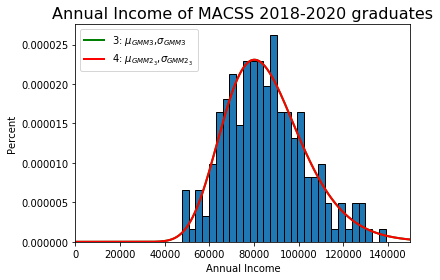

In [30]:
## Plot the histogram of data

count, bins, ignored = plt.hist(income, 30, density=True,
                                edgecolor='k')
plt.title('Annual Income of MACSS 2018-2020 graduates', fontsize=16)
plt.xlabel(r'Annual Income')
plt.ylabel(r'Percent')
plt.xlim([0, 150000])  

# Plot the estimated GMM PDF
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM_3, sig_GMM_3, 0.0, 150000),
         linewidth=2, color='g', label='3: $\mu_{GMM3}$,$\sigma_{GMM3}$')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, 0.0, 150000),
         linewidth=2, color='r', label='4: $\mu_{GMM2_3}$,$\sigma_{GMM2_3}$')
plt.legend(loc='upper left')
plt.show()

In [31]:
#Q1f

In [32]:
mu = [mu_GMM1, mu_GMM2, mu_GMM_3, mu_GMM2_3]
sigma = [sig_GMM1, sig_GMM2, sig_GMM_3, sig_GMM2_3]
gmm = [results.fun[0,0], results_2.fun[0,0], results_3.fun[0,0], results2_3.fun[0,0]]
data_2 = {'$\mu$':mu, '$\sigma$':sigma, 'GMM Value':gmm}
pd.DataFrame(data_2)


,$\mu$,$\sigma$,GMM Value
0,11.333600,0.213255,6.399283e-16
1,11.333600,0.213255,4.285285e-16
2,11.336705,0.211514,2.443700e-15
3,11.336705,0.211513,7.585876e-13


In [33]:
print('The best fitting model is the one with lowest GMM function value, which is the model from #Q1c. This model uses two moments with two steps optimal weighting matrix. ')

The best fitting model is the one with lowest GMM function value, which is the model from #Q1c. This model uses two moments with two steps optimal weighting matrix. 


In [34]:
#Q2

In [35]:
sick = pd.read_csv('/Users/liujingyang/Desktop/sick.txt')

In [36]:
## Define moment errors

def err(sick, b0, b1, b2, b3):
    y_hat = b0 + b1 * sick['age'] + b2 * sick['children'] + b3 * sick['avgtemp_winter']
    e = y_hat - sick['sick']
    e = np.array(e)
    return e

In [37]:
## Define GMM sum of squared moment errors criterion function value

def criterion(params, *args):
    b0, b1, b2, b3 = params
    sick, W = args
    e = err(sick, b0, b1, b2, b3)
    crit_val = e.T @ W @ e
    
    return crit_val

In [38]:
params_init = np.array([0.0, 0.0, 0.0, 0.0])
W = np.eye(sick.shape[0])
gmm_args = (sick, W)
results_sick = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B')
b0 = results_sick.x[0]
b1 = results_sick.x[1]
b2 = results_sick.x[2]
b3 = results_sick.x[3]

In [39]:
print('b0 estimation =', b0)
print('b1 estimation =', b1)
print('b2 estimation =', b2)
print('b3 estimation =', b3)
print('GMM criterion function Value =', results_sick.fun)

b0 estimation = 0.2516447083216073
b1 estimation = 0.012933458390041739
b2 estimation = 0.4005011085237505
b3 estimation = -0.009991699351417332
GMM criterion function Value = 0.0018212898067556803
